# HW12

## vsg247

In [112]:
import numpy as np
import ast
# note this is python2 compatible only. the pykriging code is also python2 only
import urllib2
import urllib
from cStringIO import StringIO
import json
import geopandas as gpd
import pandas as pd
import shapely
from fiona.crs import from_epsg
import pylab as pl
from scipy.spatial.distance import pdist, squareform

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Get the Data from Carto through a SQL query

In [2]:
# path to the DB
SQL_SOURCE = 'https://fb55.carto.com/api/v2/sql'

# function to query the DB remotely 
def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    """ queries a url with an sql compatible search
    Arguments:
    query : the sql query string
    format : the expected format
    source " the url of the API
    """
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

In [4]:
# within a single query collect AND GROUP the data by zipcode
facilityQuery = '''
SELECT count(*), zipcodes FROM NYCAsthmasDismissals
GROUP BY zipcodes
'''
facilityStream = queryCartoDB(facilityQuery, format='JSON')
facilityData   = json.loads(facilityStream.read())
facilityData
facilities     = pd.DataFrame.from_dict(facilityData['rows'])
facilities

,count,zipcodes
0,1699,10461
1,405,11373
2,1698,10451
3,220,11691
4,246,11375
5,494,10466
6,713,11212
7,167,11229
8,521,11215
9,386,11220


# Find a shape file with zipcode shapes for NYC, download it and open it with geopandas.

In [5]:
url = 'https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/HW11_fb55/nyc-zip-code-tabulation-areas-polygons.geojson'
json_response = urllib.urlopen(url)
response = json.loads(json_response.read().decode("utf-8"))

In [7]:
Nfeat = len(response['features'])
Nfeat

262

In [24]:
# the json file has 262 features
# from each feature we need the geometry and the zipcode

nyc_zip = gpd.GeoDataFrame()
nyc_zip['zipcodes']=[]
nyc_zip['geometry']=[]

for i in range(Nfeat):
    zipcode = response['features'][i]['properties']['postalCode']
    geometry = shapely.geometry.Polygon(response['features'][i]['geometry']['coordinates'][0])
    nyc_zip = nyc_zip.append({'geometry': geometry , 'zipcodes': zipcode}, ignore_index=True)

nyc_zip['zip_int'] = nyc_zip['zipcodes'].astype(int)
nyc_zip.set_index('zip_int', inplace=True)    
nyc_zip.head()

,zipcodes,geometry
zip_int,,
11372,11372,POLYGON ((-73.86942457284175 40.74915687096787...
11004,11004,POLYGON ((-73.71068374074007 40.75004039450917...
11040,11040,POLYGON ((-73.70098278625547 40.73889569923034...
11426,11426,POLYGON ((-73.72270447144122 40.75373371438336...
11365,11365,POLYGON ((-73.81088634744755 40.72717187575918...


# Merge the dataframe with the facility dismissals (the file you got on Carto)  joining on the zipcode and  use the zipcode geometry centers to extract the x and y coordinates of the zipcode center.

In [53]:
nyc_zip['zipcodes'] = nyc_zip.index

In [85]:
merged = pd.merge(facilities, nyc_zip, on='zipcodes')
merged

,count,zipcodes,geometry
0,1699,10461,POLYGON ((-73.84218235210301 40.83537416906358...
1,405,11373,POLYGON ((-73.88722098467157 40.72752618766134...
2,1698,10451,POLYGON ((-73.93293579565668 40.82772456126229...
3,220,11691,POLYGON ((-73.74690978489082 40.61172518196241...
4,246,11375,"POLYGON ((-73.8562474640478 40.7367227854824, ..."
5,494,10466,POLYGON ((-73.84463568041262 40.90475111227086...
6,713,11212,"POLYGON ((-73.9029413249695 40.67084010909053,..."
7,167,11229,POLYGON ((-73.94482770466587 40.61604622884872...
8,521,11215,POLYGON ((-73.98852518893619 40.67954524336321...
9,386,11220,POLYGON ((-74.02449181735253 40.65092060618561...


In [87]:
geomerged = gpd.GeoDataFrame(merged)
type(geomerged)

geopandas.geodataframe.GeoDataFrame

In [88]:
geomerged.crs

In [89]:
geomerged.crs = from_epsg(4326)
geomerged = geomerged.to_crs(epsg=2263) #US feet
geomerged.head()

,count,zipcodes,geometry
0,1699,10461,"POLYGON ((1027920.925769477 243665.9881113232,..."
1,405,11373,"POLYGON ((1015508.538520812 204354.0880607395,..."
2,1698,10451,"POLYGON ((1002809.98977098 240846.7194716614, ..."
3,220,11691,"POLYGON ((1054519.887663305 162245.880610662, ..."
4,246,11375,"POLYGON ((1024087.848133821 207717.2624367315,..."


In [90]:
geomerged['geometry']= geomerged.geometry.centroid
geomerged.head()

,count,zipcodes,geometry
0,1699,10461,POINT (1028293.521922282 247902.5491998894)
1,405,11373,POINT (1017940.176803979 208484.2631296574)
2,1698,10451,POINT (1005358.679665448 238318.1400382799)
3,220,11691,POINT (1050362.334509322 158232.1726125965)
4,246,11375,POINT (1026860.707186352 201881.500496663)


# Numpy array with x-location, y-location, number of dismissals

In [ ]:
krigdata = np.zeros((len(geomerged),3))

In [107]:
krigdata[:,0]=np.array([geomerged.geometry[i].x for i in xrange(len(geomerged))])
krigdata[:,1]=np.array([geomerged.geometry[i].y for i in xrange(len(geomerged))])
krigdata[:,2]=np.array(geomerged.iloc[:,0])

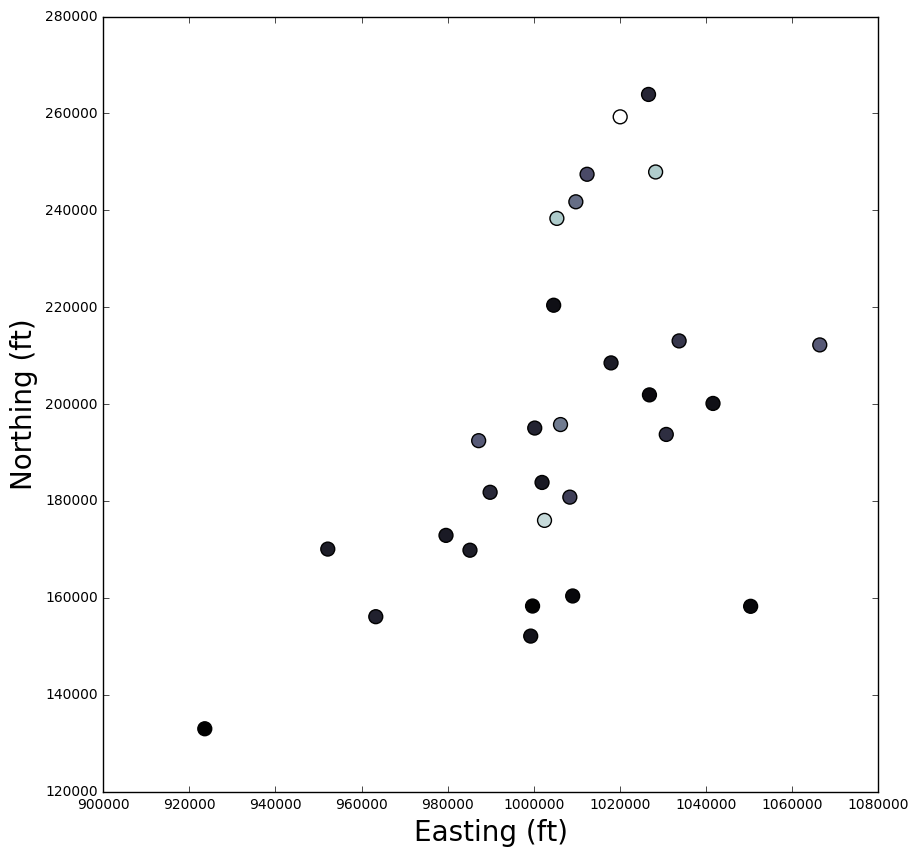

In [111]:
pl.figure(figsize=(10,10))
pl.scatter(krigdata[:,0], krigdata[:,1], c=krigdata[:,2], s=100, cmap='bone')
pl.xlabel("Easting (ft)", fontsize=20)
pl.ylabel("Northing (ft)", fontsize=20)


**FIGURE 01: Spatial distribution of the number of Asthma dismissals. Each point represents the centroid of a Zip Code in NYC.**

# Kriging

In [116]:
def SVh_vctzd( P, h, bw ):
    '''
    Experimental semivariogram for a single lag
    bw max distance
    h lag
    P data
    '''
    pdsv = squareform( pdist( P[:,:2] ) )
    #print pdsv
    N = pdsv.shape[0]
    #print N
    #print np.triu_indices(N)
    Z = np.zeros((N,N))
    Z = Z - P[:,2]
    #print Z
    Z = Z.T + P[:,2]
    #print Z
    Z = Z**2
    #print Z
    Zcd =  Z[(pdsv >= h - bw) * (pdsv <= h + bw) * \
            (~np.identity(N, dtype=bool))]

    #print Zcd
    return np.sum( Zcd ) / ( 2.0 * len( Zcd ) )

In [115]:
def SV( P, hs, bw ):
    '''
    Experimental variogram for a collection of lags
    '''
    sv = list()
    for h in hs:
        #print h
        #sv.append( SVh( P, h, bw ) )
        sv.append( SVh_vctzd ( P, h, bw ) )
    sv = [ [ hs[i], sv[i] ] for i in range( len( hs ) ) if sv[i] > 0 ]
    return np.array( sv ).T

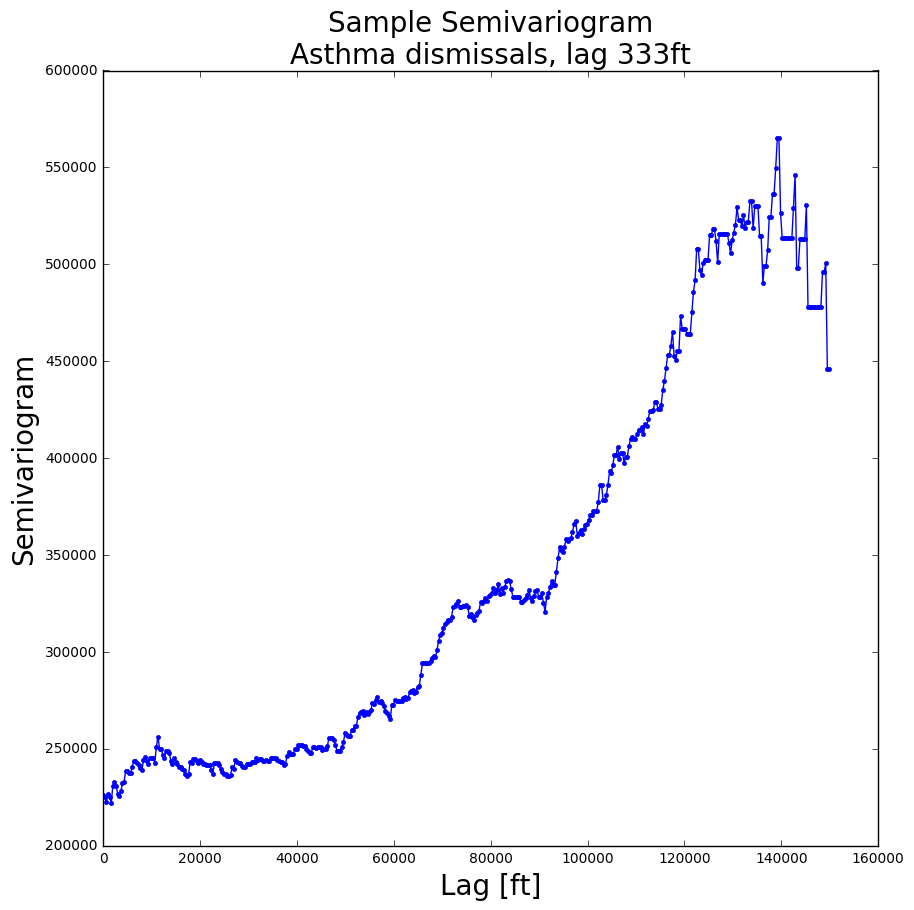

In [137]:
# steps of 100 m (lag=333)
# bandwidth of 90000 ft (for each point check the radius that corresponds to
# half of the max distance in FIGURE 01)
lag = 333
bw = 40000

# lags in 100 meter increments from zero to 180,000
hs = np.arange(0, 150001, lag)
mysv = SV( krigdata, hs, bw )
pl.figure(figsize=(10,10))
plot( mysv[0], mysv[1], '.-' )
pl.xlabel('Lag [ft]', fontsize=20)
pl.ylabel('Semivariogram', fontsize=20)
pl.title('Sample Semivariogram\nAsthma dismissals, lag %dft'%lag, fontsize=20) 

** FIGURE 02: Semivarioagram of Asthma dismissal where all the cases are centralized on the centroid of NYC zip codes. The lag was analyzed every 100 meters in a bandwidth of 40000 ft (around 13.333 mt).** 

It does not make sense to analyze the semivariogram with lags higher than the maximum distance between the data points we have, which is around 140,000 ft. Nevertheless, with a high resolution of the lag steps (every 100 m) and with a bandwidth of about 30% of this maximum distance (40,000 feet), the semivariogram seems to indicate a pattern. It would be needed still to see which would be the best model to fit this pattern within this region (lag < 140,000 ft).  

Besides that, it is also important to remember that the asthma dismissal are located where the patients went to get some treatment and not necessarily where they were exposed to what caused the asthma at first place. Therefore, this spatial correlation might be still relatively hard to explain.   